# Predicting bike rentals

Many American cities have communal bike sharing stations where people can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which I am going to work with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. [This](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset) is the direct link to download the file from the University of California, Irvine's website.

Here are the descriptions for the relevant columns:

- instant - A unique sequential ID number for each row
- dteday - The date of the rentals
- season - The season in which the rentals occurred
- yr - The year the rentals occurred
- mnth - The month the rentals occurred
- hr - The hour the rentals occurred
- holiday - Whether or not the day was a holiday
- weekday - The day of the week (as a number, 0 to 7)
- workingday - Whether or not the day was a working day
- weathersit - The weather (as a categorical variable)
- temp - The temperature, on a 0-1 scale
- atemp - The adjusted temperature
- hum - The humidity, on a 0-1 scale
- windspeed - The wind speed, on a 0-1 scale
- casual - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
- registered - The number of registered riders (people who had already signed up)
- cnt - The total number of bike rentals (casual + registered)

In this project, I am going to try to predict the total number of bikes people rented in a given hour. I'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, I'll create a few different machine learning models and evaluate their performance. 

Let's do it!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('hour.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Text(0, 0.5, 'Number of occurences')

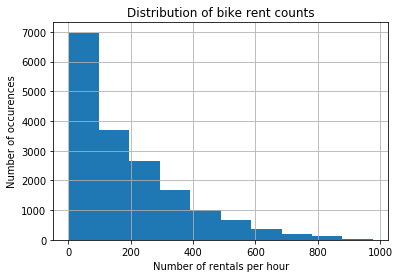

In [3]:
data['cnt'].hist()
plt.title('Distribution of bike rent counts')
plt.xlabel('Number of rentals per hour')
plt.ylabel('Number of occurences')

Let's investigate the correlations between the different variables

In [4]:
corr_coefficients = abs(data.corr()['cnt'])
corr_coefficients.sort_values(ascending = False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
instant       0.278379
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

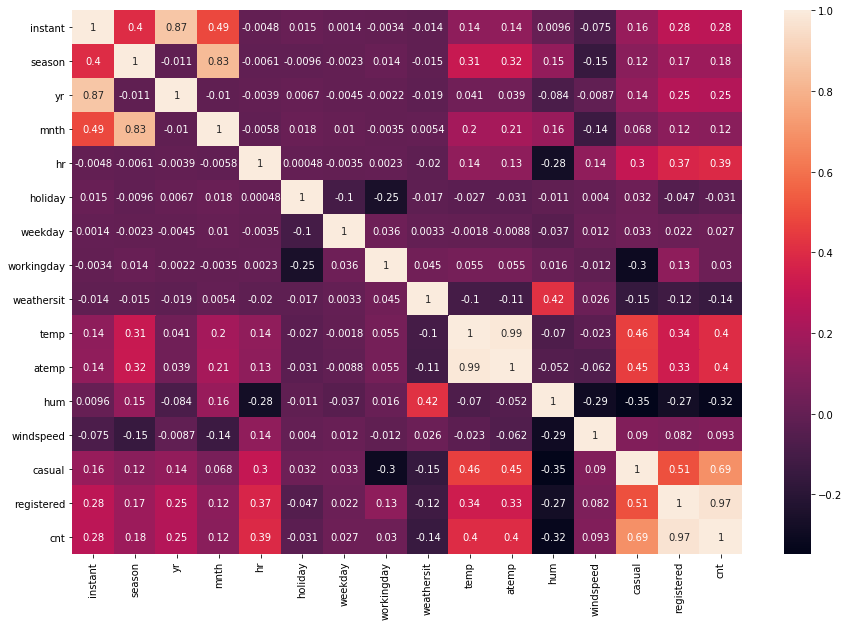

In [5]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)

Registered and casual columns have very high correlation with the target variable cnt. We will drop both since casual + registered = cnt.

## Feature engineering and selection

## 1) Adding time_label feature

The hr column contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

The following is how I'll translate hr column into time_labels:
- 1 if the hour is from 6 to 12
- 2 if the hour is from 12 to 18
- 3 if the hour is from 18 to 24
- 4 if the hour is from 0 to 6

In [6]:
data.hr.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [7]:
def time_label(h):
    if h in range(6,12):
        label = 1
    elif h in range(12,18):
        label = 2
    elif h in range(18,24):
        label = 3
    elif h in range(0,6):
        label = 4
    return label
# apply method is one of my favorites. I love it!
data['time_label'] = data['hr'].apply(time_label)

In [8]:
data.time_label.unique()

array([4, 1, 2, 3])

In [9]:
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## 2) Selecting features 

- As mentioned aboveregistered and casual columns will be dropped
- atemp and temp variables are highly correlated. Keeping only temp is enough for the purpose of the work
- instant is pointless since it is just an id
- dteday is a repetition of other variables like yr, mnth, weekday etc... To be dropped

In [10]:
exclude = ['instant','dteday','casual','registered','atemp']
data = data.drop(exclude, axis=1)
data.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,time_label
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16,4
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40,4
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32,4
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13,4
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,4


## 3) Dealing with categorical data

Categorical variables require special attention in regression analysis because, unlike dichotomous or continuous variables, they cannot by entered into the regression equation just as they are.  Instead, they need to be recoded into a series of variables which can then be entered into the regression model.  There are a variety of coding systems that can be used when recoding categorical variables. I will use a method called dummy coding.

It is a way to make the categorical variable into a series of dichotomous variables (variables that can have a value of zero or one only.)  For all but one of the levels of the categorical variable, a new variable will be created that has a value of one for each observation at that level and zero for all others.

In [11]:
# This function transforms categorical variable to dummy variables
def cat2dum(df,cols):
    D = df.copy()
    for col in cols:
        D[col] = D[col].astype('category')
        dummy = pd.get_dummies(D[col], prefix=col)
        del D[col]
        D = pd.concat([D, dummy], axis=1)
    return D

In order to experiment the influence of dummy varibles, I will split the data into data and data_d.


- data is the original data set
- data_d is the transformed data set with dummy varibles

In [12]:
# The second input contains the categorical columns to be transformed
data_d = cat2dum(data, ['season', 'mnth', 'weekday', 'weathersit', 'time_label'])
data_d.head()

,yr,hr,holiday,workingday,temp,hum,windspeed,cnt,season_1,season_2,...,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,time_label_1,time_label_2,time_label_3,time_label_4
0,0,0,0,0,0.24,0.81,0.0,16,1,0,...,0,1,1,0,0,0,0,0,0,1
1,0,1,0,0,0.22,0.80,0.0,40,1,0,...,0,1,1,0,0,0,0,0,0,1
2,0,2,0,0,0.22,0.80,0.0,32,1,0,...,0,1,1,0,0,0,0,0,0,1
3,0,3,0,0,0.24,0.75,0.0,13,1,0,...,0,1,1,0,0,0,0,0,0,1
4,0,4,0,0,0.24,0.75,0.0,1,1,0,...,0,1,1,0,0,0,0,0,0,1


## 4) Splitting data

In [13]:
# I will work with 80%/20% train/test ratio
train, test, train_d, test_d = train_test_split(data, data_d, test_size=0.2)

(train, test) are extracted from data and (train_d, test_d) are extracted from the dummy data data_d

Let's drop the traget variable cnt and form the features vector

In [14]:
features = train.columns.drop(['cnt'])
features

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'time_label'],
      dtype='object')

Data_d, I didn't forget about you! 

Same operation with data_d

In [15]:
features_d = train_d.columns.drop('cnt')
features_d

Index(['yr', 'hr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_1', 'season_2', 'season_3', 'season_4', 'mnth_1', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'time_label_1',
       'time_label_2', 'time_label_3', 'time_label_4'],
      dtype='object')

# Let's create our models and predicting some values

## 1) Linear regression model

In [16]:
def LR(train, test, features, target):
    model = LinearRegression()
    model.fit(train[features], train[target])
    pred = model.predict(test[features])
    MSE = mean_squared_error(test[target], pred)
    RMSE = np.sqrt(MSE)
    r2 = r2_score(test[target], pred)
    return RMSE, r2

train_error = LR(train, train, features, 'cnt')
test_error = LR(train, test, features, 'cnt')
print("Linear Regression:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error)
print("validation error (RMSE, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

print('')
print('')

train_error_d = LR(train_d, train_d, features_d, 'cnt')
test_error_d = LR(train_d, test_d, features_d, 'cnt')
print("Linear Regression with dummy variables:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error_d)
print("validation error (RMSE, r2):", test_error_d)
print("Difference: ", test_error_d[0] - train_error_d[0])

Linear Regression:
_____________________________________________________________________
train error (RMSE, r2): (132.88971646720736, 0.4666001811867182)
validation error (RMSE, r2): (130.02076404469318, 0.4727222147558374)
Difference:  -2.868952422514184


Linear Regression with dummy variables:
_____________________________________________________________________
train error (RMSE, r2): (127.98932422205247, 0.5052137681642189)
validation error (RMSE, r2): (125.10679943486855, 0.511824618241791)
Difference:  -2.8825247871839252


In both scenarios, the error seems to be quite high and the train error is slightly higher than the test error. The model is probably underfitting the data.

## 2) Decision tree regressor model

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and the minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

In [17]:
def DT(train, test, features, target, min_samples_leaf = 1, max_depth = None):
    model = DecisionTreeRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    model.fit(train[features], train[target])
    pred = model.predict(test[features])
    MSE = mean_squared_error(test[target], pred)
    RMSE = np.sqrt(MSE)
    r2 = r2_score(test[target], pred)
    return RMSE, r2

train_error = DT(train, train, features, 'cnt')
test_error = DT(train, test, features, 'cnt')
print("Decision tree regression:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error)
print("validation error (RMSE, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

print('')
print('')

train_error_d = DT(train_d, train_d, features_d, 'cnt')
test_error_d = DT(train_d, test_d, features_d, 'cnt')
print("Decision tree regression with dummy variables:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error_d)
print("validation error (RMSE, r2):", test_error_d)
print("Difference: ", test_error_d[0] - train_error_d[0])

Decision tree regression:
_____________________________________________________________________
train error (RMSE, r2): (0.5429810809691632, 0.9999910948854619)
validation error (RMSE, r2): (61.08023489588681, 0.8836368567682356)
Difference:  60.53725381491765


Decision tree regression with dummy variables:
_____________________________________________________________________
train error (RMSE, r2): (0.5429810809691632, 0.9999910948854619)
validation error (RMSE, r2): (61.794280932189444, 0.8809003150129215)
Difference:  61.25129985122028


This model predicts makes much better predictions since both train and validation errors decreased significantly. But the difference between the latter errors is too hight. This is a reason to say that the model is overfitting. 

Let's tune some of the model varibles and find a tradeoff.

In [18]:
dt_train_rmses = []
dt_test_rmses = []
for i in range (1, 20, 1):
    dt_train_error = DT(train, train, features, 'cnt', i)
    dt_test_error = DT(train, test, features, 'cnt', i)
    dt_train_rmses.append(dt_train_error[0])
    dt_test_rmses.append(dt_test_error[0])
    
dt_train_rmses_d = []
dt_test_rmses_d = []
for i in range (1, 20, 1):
    dt_train_error_d = DT(train_d, train_d, features_d, 'cnt', i)
    dt_test_error_d = DT(train_d, test_d, features_d, 'cnt', i)
    dt_train_rmses_d.append(dt_train_error_d[0])
    dt_test_rmses_d.append(dt_test_error_d[0])

Text(0.5, 1.0, 'Error of Decision Tree Regression with changing min_samples_leaf')

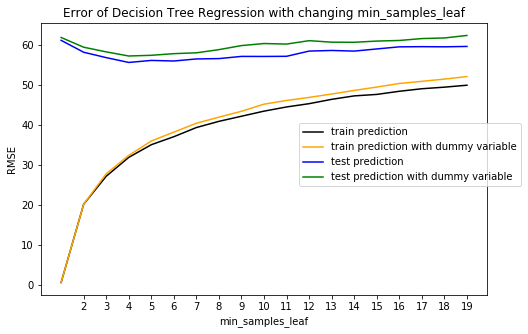

In [19]:
plt.figure(figsize=(8, 5))
x = range(1, 20, 1)
y_dt = dt_train_rmses
y_dt_d = dt_train_rmses_d
plt.plot(x,y_dt, label = 'train prediction', color='black')
plt.plot(x,y_dt_d, label = 'train prediction with dummy variable', color='orange')
Y_dt = dt_test_rmses
y2_dt_d = dt_test_rmses_d
plt.plot(x,Y_dt, label = 'test prediction', color='blue')
plt.plot(x,y2_dt_d, label = 'test prediction with dummy variable', color='green')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=10)
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 1))
plt.title("Error of Decision Tree Regression with changing min_samples_leaf")

The validation error (test error) in blue decreases to stagnate with a minimum sample leaf = 6. The train error increases bet remains lower than the validation error. The difference stagnates from min_sample_leaf = 10 roughly. Let's keep min_sample_leaf = 11 and change max_depth parameter.

The data with dummy varibles seems to not influence the predictions of decision trees. 

In [20]:
train_error = DT(train, train, features, 'cnt', 10)
test_error = DT(train, test, features, 'cnt', 10)
print("Decision tree regression with min_sample_leaf = 10:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error)
print("validation error (RMSE, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Decision tree regression with min_sample_leaf = 10:
_____________________________________________________________________
train error (RMSE, r2): (43.38398721715762, 0.9431501869136376)
validation error (RMSE, r2): (57.052926984480166, 0.8984757226764929)
Difference:  13.668939767322549


Comparing with the decision tree with the default setting, all the metrics have been improved:

- r2 score is good
- the difference between errors is reasonable 
- Both errors are lower

Text(0.5, 1.0, 'Error of Decision Tree Regression with changing max_depth')

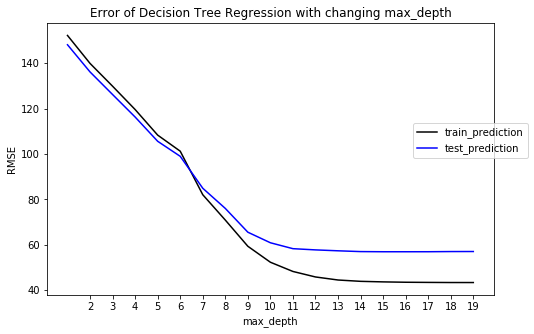

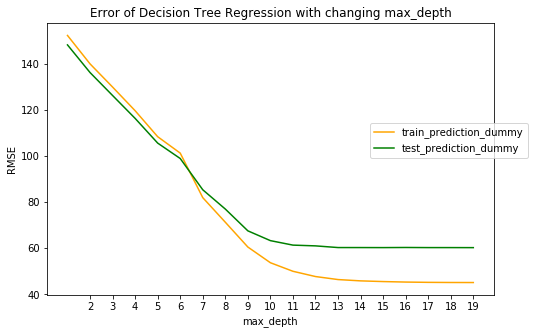

In [21]:
train_rmses = []
test_rmses = []
for i in range(1, 20, 1):
    train_error = DT(train, train, features, 'cnt', 10, i)
    test_error = DT(train, test, features, 'cnt', 10, i)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])
mean_train = np.mean(train_rmses)
mean_test = np.mean(test_rmses)

plt.figure(figsize=(8, 5))
x = range(1, 20, 1)
y1_dt = train_rmses
y2_dt = test_rmses
plt.plot(x,y1_dt, color='black', label = 'train_prediction')
plt.plot(x,y2_dt, color='blue', label = 'test_prediction')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=10)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 1))
plt.title("Error of Decision Tree Regression with changing max_depth")
#for later (last plot)
y1_dt_rf = y1_dt
y2_dt_rf = y2_dt

plt.figure(figsize=(8, 5))
train_rmses_d = []
test_rmses_d = []
for i in range(1, 20, 1):
    train_error_d = DT(train_d, train_d, features_d, 'cnt', 10, i)
    test_error_d = DT(train_d, test_d, features_d, 'cnt', 10, i)
    train_rmses_d.append(train_error_d[0])
    test_rmses_d.append(test_error_d[0])
mean_train_d = np.mean(train_rmses_d)
mean_test_d = np.mean(test_rmses_d)


x = range(1, 20, 1)
y1_dt_d = train_rmses_d
y2_dt_d = test_rmses_d
plt.plot(x,y1_dt_d, color='orange', label = 'train_prediction_dummy')
plt.plot(x,y2_dt_d, color='green', label = 'test_prediction_dummy')
plt.legend(bbox_to_anchor=(1.3,1), borderaxespad=10)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 1))
plt.title("Error of Decision Tree Regression with changing max_depth")

According to the above plot the difference between validation and training errors stays very low which is good but the errors are high. When max_depth is 9 the errors difference increased slightly but the difference between errors does not increase too much. Let's compare the metrics more precisely when max_depth is 9, 10 and 11.

Same findings for dummy varibles data.

In [22]:
train_error = DT(train, train, features, 'cnt', 11, 9)
test_error = DT(train, test, features, 'cnt', 11, 9)
print("Decision Tree Regression with min_samples_leaf = 11 and max_depth = 9")
print("_____________________________________________________________________")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0]) 
print('')
print('')
train_error = DT(train, train, features, 'cnt', 11, 10)
test_error = DT(train, test, features, 'cnt', 11, 10)
print("Decision Tree Regression with min_samples_leaf = 11 and max_depth = 10")
print("_____________________________________________________________________")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0])
print('')
print('')
train_error = DT(train, train, features, 'cnt', 11, 11)
test_error = DT(train, test, features, 'cnt', 11, 11)
print("Decision Tree Regression with min_samples_leaf = 11 and max_depth = 11")
print("_____________________________________________________________________")
print("train error:", train_error)
print("validation error:", test_error)
print("Difference: ", test_error[0] - train_error[0])

Decision Tree Regression with min_samples_leaf = 11 and max_depth = 9
_____________________________________________________________________
train error: (59.44497944701597, 0.8932665674266299)
validation error: (65.98408622151955, 0.8642022856006364)
Difference:  6.53910677450358


Decision Tree Regression with min_samples_leaf = 11 and max_depth = 10
_____________________________________________________________________
train error: (52.62228092470593, 0.9163608805941111)
validation error: (61.23095011944302, 0.8830618971508437)
Difference:  8.60866919473709


Decision Tree Regression with min_samples_leaf = 11 and max_depth = 11
_____________________________________________________________________
train error: (48.863222490950335, 0.9278835526404838)
validation error: (58.771965223338235, 0.8922655812741682)
Difference:  9.9087427323879


By comparing the results above, I will choose the Decision Tree Regression with min_samples_leaf = 11 and max_depth = 10. In fact:

- The difference between the errors is reasonable
- Both errors are lower than the default model
- r2 scores are high and very close

## 3) Random forest model

In [23]:
def RF(train, test, features, target, min_samples_leaf=2, max_depth=None):
    model = RandomForestRegressor(random_state=1, min_samples_leaf=min_samples_leaf, max_depth = max_depth)
    model.fit(train[features], train[target])
    predictions = model.predict(test[features])
    MSE = mean_squared_error(test[target], predictions)
    RMSE = np.sqrt(MSE)
    r2 = r2_score(test[target], predictions)
    return RMSE, r2

train_error = RF(train, train, features, 'cnt')
test_error = RF(train, test, features, 'cnt')
print("Random forest:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error)
print("validation error (RMSE, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Random forest:
_____________________________________________________________________
train error (RMSE, r2): (23.061605886604752, 0.9839361660549061)
validation error (RMSE, r2): (43.893902983527745, 0.9399071992436405)
Difference:  20.832297096922993


In [24]:
train_rmses_rf = []
test_rmses_rf = []
for i in range(2, 20, 1):
    train_error = RF(train, train, features, 'cnt', i, None)
    test_error = RF(train, test, features, 'cnt', i, None)
    train_rmses_rf.append(train_error[0])
    test_rmses_rf.append(test_error[0])

Text(0.5, 1.0, 'Error comparison of Random Forest and Decision Tree with changing min_samples_leaf')

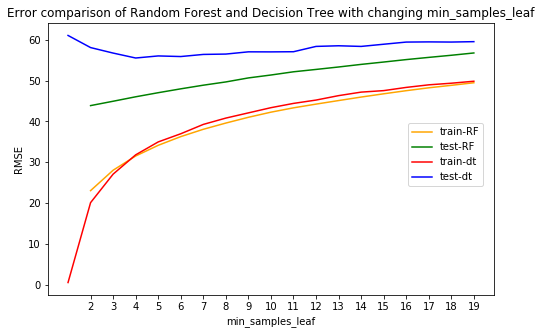

In [25]:
plt.figure(figsize=(8, 5))
x = range(2, 20, 1)
y1 = train_rmses_rf
y2 = test_rmses_rf
plt.plot(x,y1, color='orange', label = 'train-RF')
plt.plot(x,y2, color='green', label = 'test-RF')
plt.plot(range(1, 20, 1),y_dt, color='red', label = 'train-dt')
plt.plot(range(1, 20, 1),Y_dt, color='blue', label = 'test-dt')
plt.xlabel('min_samples_leaf')
plt.ylabel('RMSE')
plt.xticks(range(2, 20, 1))
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=10)
plt.title('Error comparison of Random Forest and Decision Tree with changing min_samples_leaf')

The above plot shows clearly that the random forest model gives lower validation errors than the decision tree. The difference between errors is also decreased for all min_samples_leaf so the random forest seems more fitted. Let's choose min_samples_leaf = 11 and change max_depth to see if we can get better results.

In [26]:
train_rmses = []
test_rmses = []
for i in range(2, 20, 1):
    train_error = RF(train, train, features, 'cnt', 10, i)
    test_error = RF(train, test, features, 'cnt', 10, i)
    train_rmses.append(train_error[0])
    test_rmses.append(test_error[0])

Text(0.5, 1.0, 'Error comparison of Random Forest and Decision Tree with changing max_depth')

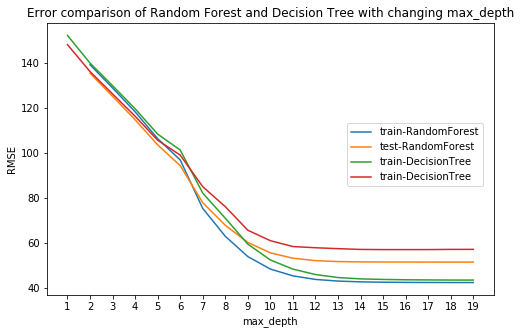

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 20, 1), train_rmses, label='train-RandomForest')
plt.plot(range(2, 20, 1), test_rmses, label='test-RandomForest')
plt.plot(range(1, 20, 1), y1_dt_rf, label='train-DecisionTree')
plt.plot(range(1, 20, 1), y2_dt_rf, label='train-DecisionTree')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.xticks(range(1, 20, 1))
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=10)
plt.title('Error comparison of Random Forest and Decision Tree with changing max_depth')

In [28]:
train_error = RF(train, train, features, 'cnt', 11, 11)
test_error = RF(train, test, features, 'cnt', 11, 11)
print("Random forest:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error)
print("validation error (RMSE, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Random forest:
_____________________________________________________________________
train error (RMSE, r2): (45.979787833972914, 0.9361436574574077)
validation error (RMSE, r2): (53.761901519952204, 0.9098505069345711)
Difference:  7.78211368597929


In [29]:
train_error = RF(train, train, features, 'cnt', 11, 10)
test_error = RF(train, test, features, 'cnt', 11, 10)
print("Random forest:")
print("_____________________________________________________________________")
print("train error (RMSE, r2):", train_error)
print("validation error (RMSE, r2):", test_error)
print("Difference: ", test_error[0] - train_error[0])

Random forest:
_____________________________________________________________________
train error (RMSE, r2): (48.758254317657844, 0.9281930615299556)
validation error (RMSE, r2): (55.96185774208702, 0.902321654861219)
Difference:  7.203603424429176


It seems the random forest algorithm with min_samples_leaf = 11 and max_depth = 10 is the best algorithm among the models we have tried to predict bike rentals.

# Conclusion

In this project, I have tried some mdels to predict bike rentals. Let's compare the models I have tried in one table using the following abreviations:
- LR: Linear Regreassion
- DT: Decision Tree Regression
- RF: Random Forest

In [30]:
algorithms = pd.DataFrame(index = ['LR', 'DT Default', 'DT with min_samples_leaf = 10', 'DT with min_samples_leaf = 11 and max_depth = 10', 'RF Default', 'RF with min_samples_leaf = 11 and max_depth = 10'],
            columns = ['train_rsme', 'train_r2', 'test_rsme', 'test_r2', 'diff_rsme'], 
            data = np.array([[132.88, 0.47, 130.02, 0.47, -2.87],
                             [0.54, 0.99, 61.08, 0.88, 60.54],
                             [43.38, 0.94, 57.05, 0.90, 13.66],
                             [52.62, 0.91, 61.23, 0.88, 8.61],
                             [23.06, 0.98, 43.90, 0.94, 20.83],
                             [48.76, 0.93, 55.96, 0.90, 7.20]]))
algorithms

,train_rsme,train_r2,test_rsme,test_r2,diff_rsme
LR,132.88,0.47,130.02,0.47,-2.87
DT Default,0.54,0.99,61.08,0.88,60.54
DT with min_samples_leaf = 10,43.38,0.94,57.05,0.90,13.66
DT with min_samples_leaf = 11 and max_depth = 10,52.62,0.91,61.23,0.88,8.61
RF Default,23.06,0.98,43.90,0.94,20.83
RF with min_samples_leaf = 11 and max_depth = 10,48.76,0.93,55.96,0.90,7.20


Among the above models Random Forest with min_samples_leaf = 11 and max_depth = 10 has shown the best result. Although some other models show lower errors they seem overfitted because of too high r square and higher training error than validation error. This result has been achieved by applying trade-off between the following criteria:

- lower RSME
- lower difference between training and validation errors to prevent overfitting
- high R square but not too high to find the fitted algorithm but not overfitted one.

Next steps: Here are some potential next steps:

Calculate additional features, such as:

- An index combining temperature, humidity, and wind speed
- Try predicting casual and registered instead of cnt
